# MAS evaluation hypothesis 

In this Notebook we analyse the regarding the hypothesis

In [ ]:
import pandas as pd 
import numpy as np 
import itertools
import statsmodels.api as sm
from scipy.stats import friedmanchisquare, wilcoxon, chi2, ncx2, norm
from statsmodels.stats.multitest import multipletests
from typing import Dict, List, Tuple
import json
from foodrec.config.structure.dataset_enum import ModelEnum 
from foodrec.evaluation.is_ketogen import is_ketogenic, calc_keto_ratio
from foodrec.config.structure.paths import CONVERSATION, DATASET_PATHS
from analysis_helper.metrics import macro_over_queries, micro_over_queries, accuracy,plot_pr_curves, f1_score, mean_average_precision_over_queries, mean_pr_auc_over_queries, bias_conformity_rate_at_k
from analysis_helper.load_dataset import get_dicts_set, get_search_engine


## Get Dataset

In [64]:
query_set = pd.read_csv(DATASET_PATHS / "zw_personas.csv")
model = ModelEnum.Gemini

In [66]:
def get_paths(model_name):
    return {
        "PATH_NO_BIASE": CONVERSATION / model_name / "no_biase",
        "PATH_SYSTEM_BIASE": CONVERSATION / model_name / "system_biase",
        "PATH_SEARCH_ENGINE": CONVERSATION / ModelEnum.Gemini.name / "search_engine" / "res_one.json",
        "PATH_SEARCH_BIASE": CONVERSATION / model_name / "search_biase" ,
        "PATH_BOTH": CONVERSATION / model_name / "both_biase"
    }

In [67]:
paths = get_paths(ModelEnum.Gemini.name)

## Regarding H1: A MAS with Expert Knowledge achieves a higher rate of keto-compliant recipe recommendations compared to the baseline without Expert Prompt.
### Rationale: Expert knowledge explicitly emphasizes keto-relevant terms during reasoning, guiding the system to prioritize ketogenic recipes and thereby increasing the proportion of keto-compliant recommendations.

What do i need:
abbildung pr_auc kurve
statistische tests

In [ ]:
def get_metrics(pred: Dict[str, List[bool]], gt: Dict[str, List[bool]], verbose: bool = True) -> Dict[str, float]:
    common = [k for k in pred.keys() if k in gt]

    ls_accuracy = [pred[q][0] for q in common if pred[q]]
    mean_response_length = np.mean([len(pred[q]) for q in common if pred[q]])
    macro_precision, macro_recall = macro_over_queries(gt, pred)
    micro_precision, micro_recall = micro_over_queries(gt, pred)
    mean_average_precision = mean_average_precision_over_queries(gt)

    accuracy_val = accuracy(ls_accuracy) if ls_accuracy else float('nan')

    mean_length = np.mean([len(gt[q]) for q in common]) if common else float('nan')
    mean_pr_auc = mean_pr_auc_over_queries(pred)
    conformity_at_1 = bias_conformity_rate_at_k(pred, k=1)
    conformity_at_3 = bias_conformity_rate_at_k(pred, k=3)
    conformity_at_5 = bias_conformity_rate_at_k(pred, k=5)

    ratios = []
    for q in common:
        gt_len = len(gt[q])
        if gt_len > 0:
            pred_len = len(pred.get(q) or [])
            ratios.append(pred_len / gt_len)
    median_hit_ratio = np.median(ratios) if ratios else float('nan')

    results = {
        "Macro Precision": macro_precision,
        "Macro Recall": macro_recall,
        "Macro F1": f1_score(macro_precision, macro_recall),
        "Micro Precision": micro_precision,
        "Micro Recall": micro_recall,
        "Micro F1": f1_score(micro_precision, micro_recall),
        "Mean Average Precision": mean_average_precision,
        "Mean PR-AUC": mean_pr_auc,
        "Mean Length of Search Results": mean_length,
        "Mean Response Length": mean_response_length,
        "Median Hit Length": median_hit_ratio,
        "Bias Conformity@1": conformity_at_1,
        "Bias Conformity@3": conformity_at_3,
        "Bias Conformity@5": conformity_at_5,
        "Accuracy": accuracy_val,
    }

    if verbose:
        for k, v in results.items():
            print(f"{k}: {v:.4f}" if isinstance(v, (float, int)) else f"{k}: {v}")

    return results


In [81]:
def check_ketogenic_biase(
    dict_biase: Dict[str, List[dict]],
    search_gt: Dict[str, List[dict]],
    keto_ratio_index: float = 0.8,
) -> Tuple[Dict[str, List[bool]], Dict[str, List[bool]]]:
    """
    Returns:
      pred_dict: keto flags for items the system selected (dict_biase)
      gt_dict:   keto flags for items NOT selected by the system (search_gt \ dict_biase)
    """
    f_is_keto = is_ketogenic  # local binding

    def to_keto_flags(d: Dict[str, List[dict]]) -> Dict[str, List[bool]]:
        out: Dict[str, List[bool]] = {}
        for key, items in d.items():
            flags = []
            for item in items or []:  # falls None oder leere Liste
                try:
                    flags.append(
                        f_is_keto(
                            calories=item.get("calories", 0),
                            protein_g=item.get("proteins", 0),
                            fat_g=item.get("fat", 0),
                            carbs_g=item.get("carbohydrates", 0),
                            keto_ratio_index=keto_ratio_index,
                        )
                    )
                except Exception:
                    # bei Fehler einfach False anhängen
                    flags.append(False)
            out[key] = flags
        return out

    pred_dict = to_keto_flags(dict_biase)
    gt_dict   = to_keto_flags(search_gt)
    return (pred_dict, pred_dict) if not gt_dict else (pred_dict, gt_dict)

In [ ]:
import pandas as pd
import numpy as np

def calc_metrics(query_set, paths, model_name: ModelEnum, save_csv: str | None = None, ref_include = False) -> pd.DataFrame:
    """
    Calculates metrics for all bias variants and returns them as a DataFrame.
    Optional: Saves the table as CSV if save_csv is a path.
    Expected: get_metrics(pred, gt, verbose=False) -> Dict[str, float]
    """
    dict_search_engine, dict_search_engine_search = get_search_engine(paths['PATH_SEARCH_ENGINE'])
    dict_system_biase,  dict_system_biase_search, ref_system_biase  = get_dicts_set(df=query_set, model=model_name, Path=paths['PATH_SYSTEM_BIASE'])
    dict_no_biase,      dict_no_biase_search, ref_no_biase      = get_dicts_set(df=query_set, model=model_name, Path=paths['PATH_NO_BIASE'])
    dict_search_biase,  dict_search_biase_search, ref_search_biase  = get_dicts_set(query_set, model_name, paths['PATH_SEARCH_BIASE'])
    dict_both,          dict_both_search, ref_both_biase          = get_dicts_set(query_set, model_name, paths['PATH_BOTH'])

    def reduce_to_ref(dict_res: dict, dict_search: dict, ref: dict):
        """
        Reduces dict_res and dict_search to the keys that have the status decision==“ACCEPT” in ref.
        Returns the filtered Dicts. If ref is empty/None, the originals are returned.
        """
        if not ref:
            return dict_res, dict_search

        accepted_keys = {
            k for k, v in ref.items()
            if isinstance(v, dict) and v.get("decision") == "ACCEPT"
        }

        dict_res_new = {k: dict_res[k] for k in accepted_keys if k in dict_res}
        dict_search_new = {k: dict_search[k] for k in accepted_keys if k in dict_search}
        return dict_res_new, dict_search_new
    if ref_include:
        dict_system_biase,  dict_system_biase_search  = reduce_to_ref(dict_system_biase,  dict_system_biase_search,  ref_system_biase)
        dict_no_biase,      dict_no_biase_search      = reduce_to_ref(dict_no_biase,      dict_no_biase_search,      ref_no_biase)
        dict_search_biase,  dict_search_biase_search  = reduce_to_ref(dict_search_biase,  dict_search_biase_search,  ref_search_biase)
        dict_both,          dict_both_search          = reduce_to_ref(dict_both,          dict_both_search,          ref_both_biase)

    def flatten_dict(d):
        return [b for lst in d.values() for b in lst]


    variants = [
        ("No Biase",      dict_no_biase,     dict_no_biase_search),
        ("System Biase",  dict_system_biase, dict_system_biase_search),
        ("Search Engine", dict_search_engine,dict_search_engine_search),
        ("Search Biase",  dict_search_biase, dict_search_biase_search),
        ("Both Biase",    dict_both,         dict_both_search),
    ]
    pr_auc_raw = {}
    rows = []
    for name, d_predlike, d_search in variants:
        pred, gt = check_ketogenic_biase(d_predlike, d_search)
        m = get_metrics(pred, gt, verbose=False) 
        m["Bias"] = name
        pr_auc_raw[name] = (flatten_dict(gt), flatten_dict(pred))
        rows.append(m)

    df = pd.DataFrame(rows)

    preferred_cols = [
        "Bias",
        "Macro Precision", "Macro Recall", "Macro F1",
        "Micro Precision", "Micro Recall", "Micro F1",
        "Mean Average Precision", "Mean PR-AUC",
        "Mean Length of Search Results", "Mean Response Length",
        "Median Hit Length",
        "Bias Conformity@1", "Bias Conformity@3", "Bias Conformity@5",
        "Accuracy",
    ]
    cols = [c for c in preferred_cols if c in df.columns] + [c for c in df.columns if c not in preferred_cols]
    df = df[cols].set_index("Bias")

    if save_csv:
        df.to_csv(save_csv, index=True)

    print(df)
    return pr_auc_raw

In [85]:
pr_auc_raw = calc_metrics(query_set=query_set, paths=paths, model_name=ModelEnum.Gemini, ref_include=False)

9.074334875650663 100 35.023809523809526 100
68.33333333333334 100 70.0148629148629 100
10.342857142857138 100 55.0 100
92.56186868686868 100 50.07281676626731 100
97.5 100 30.43916211943088 100
               Macro Precision  Macro Recall  Macro F1  Micro Precision  \
Bias                                                                      
No Biase              0.090743      0.350238  0.144141         0.106557   
System Biase          0.683333      0.700149  0.691639         0.820276   
Search Engine         0.103429      0.550000  0.174115         0.104569   
Search Biase          0.925619      0.500728  0.649889         0.975379   
Both Biase            0.975000      0.304392  0.463942         0.997238   

               Micro Recall  Micro F1  Mean Average Precision  Mean PR-AUC  \
Bias                                                                         
No Biase           0.442177  0.171731                0.176692     0.174006   
System Biase       0.816514  0.818391        

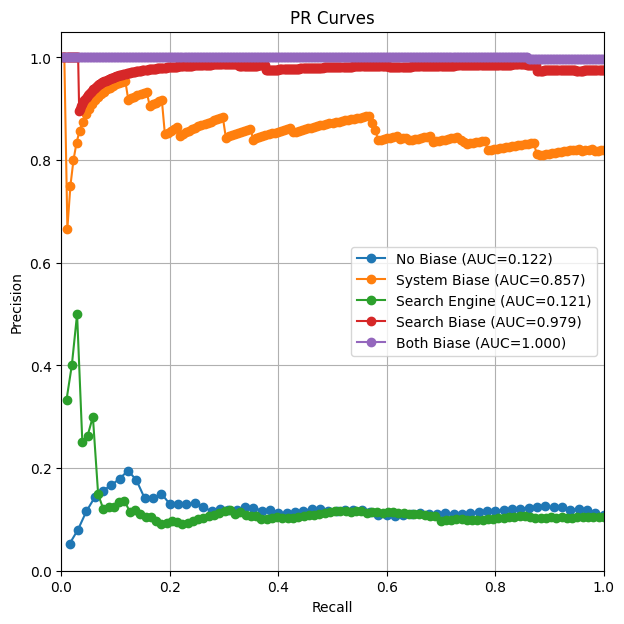

In [72]:
plot_pr_curves(pr_auc_raw)

8.434774436090224 92 33.523809523809526 92
46.666666666666664 75 52.291666666666664 75
10.342857142857138 100 55.0 100
80.70833333333334 88 46.906610766702975 88
75.5 78 27.246901663232588 78
               Macro Precision  Macro Recall  Macro F1  Micro Precision  \
Bias                                                                      
No Biase              0.091682      0.364389  0.146504         0.106572   
System Biase          0.622222      0.697222  0.657591         0.746377   
Search Engine         0.103429      0.550000  0.174115         0.104569   
Search Biase          0.917140      0.533030  0.674215         0.976139   
Both Biase            0.967949      0.349319  0.513370         0.996441   

               Micro Recall  Micro F1  Mean Average Precision  Mean PR-AUC  \
Bias                                                                         
No Biase           0.495868  0.175439                0.179249     0.171845   
System Biase       0.880342  0.807843           

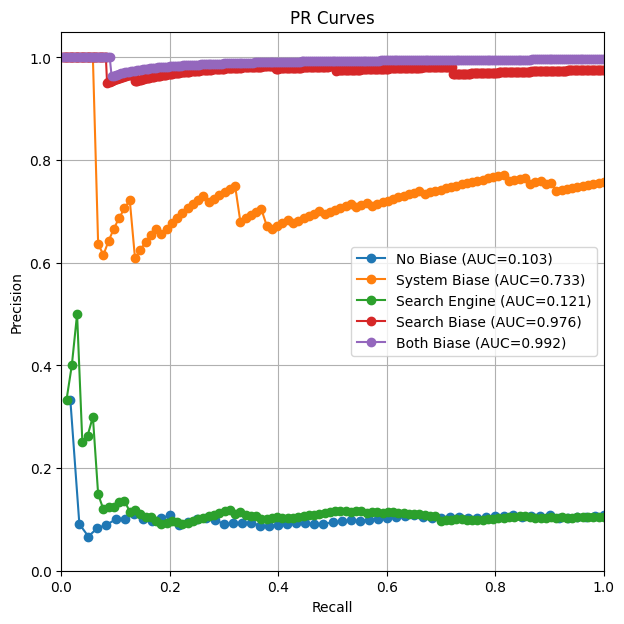

In [73]:
plot_pr_curves(calc_metrics(query_set=query_set, paths=paths, model_name=ModelEnum.Gemini, ref_include=True))

### Statistic Tests

In [48]:
dict_search_engine, dict_search_engine_search = get_search_engine(paths['PATH_SEARCH_ENGINE'])
dict_system_biase,  dict_system_biase_search, ref_system_biase  = get_dicts_set(df=query_set, model=ModelEnum.Gemini, Path=paths['PATH_SYSTEM_BIASE'])
dict_no_biase,      dict_no_biase_search, ref_no_biase      = get_dicts_set(df=query_set, model=ModelEnum.Gemini, Path=paths['PATH_NO_BIASE'])
dict_search_biase,  dict_search_biase_search, ref_search_biase  = get_dicts_set(query_set, ModelEnum.Gemini, paths['PATH_SEARCH_BIASE'])
dict_both,          dict_both_search, ref_both_biase          = get_dicts_set(query_set, ModelEnum.Gemini, paths['PATH_BOTH'])

In [49]:
def calc_keto(dict_biase: dict, df, keto_ratio_index: float = 0.8, mode: str = "top1") -> dict:
    """
    dict_biase: { query -> [ {recipe_dict}, ... ] } ODER { query -> {recipe_dict} }
    mode: 'top1' (nur erstes Rezept) oder 'any' (mind. ein Rezept ist ketogen)
    return: { query -> 0/1 }
    """
    def _is_keto(rec: dict) -> bool:
        obj = calc_keto_ratio(
            protein_g=rec.get("proteins", 0),
            fat_g=rec.get("fat", 0),
            carbs_g=rec.get("carbohydrates", 0),
        )
        if obj == np.inf:
            return 0
        return obj

    res = {}
    for _, row in df.iterrows():
        q = row["query"]

        # existiert der Query überhaupt?
        if q not in dict_biase:
            res[q] = 0
            continue

        items = dict_biase[q]

        # Normalisieren auf Liste von Rezepten
        if items is None:
            res[q] = 0
            continue
        if isinstance(items, dict):
            items = [items]
        if not isinstance(items, (list, tuple)) or len(items) == 0:
            res[q] = 0
            continue

        # Modus: top1 oder any
        if mode == "top1":
            res[q] = float(_is_keto(items[0]))
        elif mode == "any":
            res[q] = float(any(_is_keto(r) for r in items))
        else:
            raise ValueError("mode must be 'top1' or 'any'")

    return res


In [50]:
eval = {
    "SystemBiase": calc_keto(df=query_set, dict_biase=dict_system_biase),
    "NoBiase":calc_keto(df=query_set, dict_biase=dict_no_biase),
    "SearchEngine": calc_keto(df=query_set, dict_biase=dict_search_engine),
    "SearchBiase":calc_keto(df=query_set, dict_biase=dict_search_biase),
    "BothBiase":calc_keto(df=query_set, dict_biase=dict_both)
}

In [51]:
import pandas as pd

df_wide = pd.DataFrame(eval)              
df_wide = df_wide.reset_index()            
df_wide = df_wide.rename(columns={"index": "query"})
print(df_wide.head())


                                               query  SystemBiase   NoBiase  \
0  Can you suggest recipes that do not consist of...     1.287039  0.666665   
1  Can you suggest middle east or norh americam r...     0.000000  0.200705   
2  Can you suggest non-alcoholic recipes that do ...     0.000000  0.223927   
3  Can you suggest octopus recipes that do not co...     0.742267  0.094890   
4  Can you suggest  recipes that do not consist o...     1.584418  0.229927   

   SearchEngine  SearchBiase  BothBiase  
0      0.146497     1.321613   1.816664  
1      0.278652     0.951664   1.125000  
2      0.010363     0.929999   2.079266  
3      0.094890     0.000000   1.413791  
4      0.090090     0.802660   0.987011  


In [52]:
from scipy.stats import shapiro
import numpy as np

normality = []
for col in df_wide.columns:
    if col == "query": 
        continue
    x = df_wide[col].dropna().to_numpy()
    if len(x) < 3:
        print(f"{col}: zu wenige Werte (n={len(x)}) für Shapiro-Wilk.")
        continue
    stat, p = shapiro(x)
    normality.append({"Condition": col, "n": len(x), "p": p})
    print(f"{col}: Shapiro-Wilk p={p:.4f} (n={len(x)})")


SystemBiase: Shapiro-Wilk p=0.0000 (n=100)
NoBiase: Shapiro-Wilk p=0.0000 (n=100)
SearchEngine: Shapiro-Wilk p=0.0000 (n=100)
SearchBiase: Shapiro-Wilk p=0.0000 (n=100)
BothBiase: Shapiro-Wilk p=0.0000 (n=100)


In [53]:
for col in df_wide.columns:
    if col == "query": 
        continue
    x = df_wide[col].dropna().to_numpy()
    print(f"{col} Mean: {np.median(x)}")


SystemBiase Mean: 1.0536748479458466
NoBiase Mean: 0.2864317828608117
SearchEngine Mean: 0.2503780723728942
SearchBiase Mean: 0.9987117430783579
BothBiase Mean: 1.2047524428250043


In [ ]:

conds = [c for c in df_wide.columns if c != "query"]

dfc = df_wide.dropna(subset=conds).copy()
N = len(dfc)
k = len(conds)
if N == 0:
    raise ValueError("Keine vollständigen Zeilen (Queries) über alle Conditions vorhanden.")

print(f"n(Query) = {N}, k(Conditions) = {k}")

friedman_stat, friedman_p = friedmanchisquare(*[dfc[c] for c in conds])
print(f"Friedman χ²={friedman_stat:.3f}, p={friedman_p:.3e}")

W = friedman_stat / (N * (k - 1))    
df = k - 1                          
alpha = 0.05

crit = chi2.ppf(1 - alpha, df)
lam = N * (k - 1) * W
power = 1 - ncx2.cdf(crit, df, lam)

print(f"Kendall's W = {W:.3f}")
print(f"Power (α={alpha:.2f}) ≈ {power:.4f}")

def friedman_power(N_, k_, W_, alpha_=0.05):
    df_ = k_ - 1
    crit_ = chi2.ppf(1 - alpha_, df_)
    lam_ = N_ * (k_ - 1) * W_
    return float(1 - ncx2.cdf(crit_, df_, lam_))

target_power = 0.80
lo, hi = 3, max(10, N)  
while friedman_power(hi, k, W, alpha) < target_power:
    hi *= 2
while lo < hi:
    mid = (lo + hi) // 2
    if friedman_power(mid, k, W, alpha) >= target_power:
        hi = mid
    else:
        lo = mid + 1
N_needed = lo
print(f"Benötigtes N für Power ≥ {target_power:.2f}: ca. {N_needed}")

pairs = list(itertools.combinations(conds, 2))
pvals, labels, stats_W, ns, rs = [], [], [], [], []

for a, b in pairs:
    x = dfc[a].to_numpy()
    y = dfc[b].to_numpy()
    diffs = x - y
    mask = diffs != 0
    x2, y2 = x[mask], y[mask]
    n_eff = len(x2)
    if n_eff < 1:
        pvals.append(1.0)
        labels.append((a, b))
        stats_W.append(np.nan)
        ns.append(0)
        rs.append(np.nan)
        continue

    statW, p = wilcoxon(x2, y2, zero_method='wilcox', alternative='two-sided', mode='auto')
    z = norm.isf(p / 2.0)  
    sign = np.sign(np.median(diffs[mask])) if np.any(mask) else 0.0
    r = sign * z / np.sqrt(n_eff)

    pvals.append(p)
    labels.append((a, b))
    stats_W.append(statW)
    ns.append(n_eff)
    rs.append(r)

p_adj = multipletests(pvals, method="holm")[1]

res = pd.DataFrame({
    "A": [a for a, b in labels],
    "B": [b for a, b in labels],
    "n_eff": ns,
    "W_stat": stats_W,
    "p_raw": pvals,
    "p_holm": p_adj,
    "r_effect": rs,   
})
res = res.sort_values("p_holm").reset_index(drop=True)

pd.set_option('display.max_rows', None)
print("\nPost-hoc Wilcoxon (Holm-korrigiert) mit Effektgröße r:")
print(res.to_string(index=False))

print("\nHinweis: |r|≈0.10 klein, ≈0.30 mittel, ≈0.50 groß (Daumenregel).")
print("Vorzeichen von r zeigt Richtung (Median(A−B)).")


n(Query) = 100, k(Conditions) = 5
Friedman χ²=198.252, p=8.928e-42
Kendall's W = 0.496
Power (α=0.05) ≈ 1.0000
Benötigtes N für Power ≥ 0.80: ca. 7

Post-hoc Wilcoxon (Holm-korrigiert) mit Effektgröße r:
           A            B  n_eff  W_stat        p_raw       p_holm  r_effect
     NoBiase    BothBiase     98    21.0 1.588236e-17 1.588236e-16 -0.860704
SearchEngine    BothBiase     97    35.0 3.599136e-17 3.239222e-16 -0.855457
SearchEngine  SearchBiase     97   133.0 6.879528e-16 5.503623e-15 -0.819652
     NoBiase  SearchBiase     93   154.0 7.032839e-15 4.922988e-14 -0.807152
 SystemBiase      NoBiase     95   271.0 8.843044e-14 5.305826e-13  0.765085
 SystemBiase SearchEngine     96   401.0 1.896946e-12 9.484728e-12  0.718707
 SearchBiase    BothBiase     79   622.0 2.843396e-06 1.137359e-05 -0.526746
 SystemBiase    BothBiase     84  1007.5 5.253607e-04 1.576082e-03 -0.378333
     NoBiase SearchEngine     95  2017.0 3.289559e-01 6.579119e-01  0.100158
 SystemBiase  SearchBiase 

## Regarding H2:  A MAS with Expert Prompt achieves a higher task success rate (TSR \footnote{Definition TSR: A task is considered successful if the system proposes at least one recipe and this is accepted by the reflector agent.}) compared to a MAS with prefiltering. Wrong
### Rationale: For non-ketogenic queries, a MAS with Expert Prompt achieves a lower reflector task success rate (TSR \footnote{Definition TSR: A task is considered successful if the system proposes at least one recipe and this is accepted by the reflector agent.}) compared to a MAS with prefiltering.

In [90]:
def get_last_reflector_answer(persona_id: int, query: str, model: ModelEnum, Path = None):
    query_stempt = query.replace(" ", "_").lower()
    id = f"{persona_id}_{query_stempt}_{model.name}"
    ls_search = []
    reflector = {}
    filepath = Path / f"{id}.jsonl"
    if not filepath.exists():
        return 0
    
    try:
        with open(filepath, "r", encoding="utf-8") as f:
            for line in f:
                
                line = line.strip()
                if not line:
                    continue
                try:
                    obj = json.loads(line)
                except json.JSONDecodeError:
                    continue  # kaputte Zeilen überspringen
                if obj.get("role") == "REFLECTOR":
                    reflector= obj
            meta = reflector["meta"]
            decision = meta['decision']
            if decision.lower() == "accept":
                return True
            else:
                return False
    except:
        return False

In [ ]:
def calc_task_success_rate(query_set, paths, model:ModelEnum):
    def calc_individual_rate(query_set, Path, model:ModelEnum):
        ls = []
        for _, row in query_set.iterrows():
            persona_id = row["id"]
            query = row["query"]
            ls.append(get_last_reflector_answer(persona_id=persona_id, query=query, model=model, Path=Path))
        return np.mean(ls), ls     
    no_biase_mean, no_biase_raw =   calc_individual_rate(query_set= query_set, model=model, Path=paths['PATH_NO_BIASE'])
    system_biase, system_biase_raw = calc_individual_rate(query_set, model=model, Path=paths['PATH_SYSTEM_BIASE'])
    search_biase, search_biase_raw = calc_individual_rate(query_set=query_set, model=model, Path=paths['PATH_SEARCH_BIASE'])
    both_biase, search_both_biase = calc_individual_rate(query_set=query_set, model=model, Path=paths['PATH_BOTH'])
    print("Task Success Rate No Biase:", no_biase_mean)
    print("Task Success Rate Biase:", system_biase)
    print("Task Success Rate Search Biase:", search_biase)
    print("Task Success Rate Both Biase:", both_biase)
    return no_biase_raw, system_biase_raw, search_biase_raw, search_both_biase

In [92]:
no_biase_raw, system_biase_raw, search_biase_raw, search_both_biase = calc_task_success_rate(query_set=query_set, paths=paths,model=ModelEnum.Gemini)
eval_h2 = {
    "SystemBiase": system_biase_raw,
    "NoBiase":no_biase_raw,
    "SearchBiase":search_biase_raw,
    "BothBiase":search_both_biase
}

Task Success Rate No Biase: 0.92
Task Success Rate Biase: 0.75
Task Success Rate Search Biase: 0.88
Task Success Rate Both Biase: 0.78


In [ ]:
df_wide_h2 = pd.DataFrame(eval_h2)              
print(df_wide_h2.head())

   SystemBiase  NoBiase  SearchBiase  BothBiase
0         True     True         True       True
1         True     True         True       True
2         True     True         True       True
3         True     True         True      False
4         True     True         True       True


In [ ]:
cols = ["SystemBiase", "NoBiase", "SearchBiase", "BothBiase"]
X = df_wide_h2[cols].dropna()
X = X.astype(int)
res = sm.stats.cochrans_q(X) 
print(f"Cochran's Q = {res.statistic:.3f}, p = {res.pvalue:.4g}")

Cochran's Q = 17.311, p = 0.0006099


In [96]:
from statsmodels.stats.contingency_tables import mcnemar
from statsmodels.stats.multitest import multipletests
import itertools

pairs = list(itertools.combinations(cols, 2))
p_raw, stats_val, n_discord = [], [], []

for a, b in pairs:
    tab = pd.crosstab(X[a], X[b])      # 2x2
    tab = tab.reindex(index=[0,1], columns=[0,1], fill_value=0)  # ordnen & fehlende füllen

    # Anzahl discordanter Paare (01 + 10) für Wahl exact/approx
    d = int(tab.loc[0,1] + tab.loc[1,0])
    exact = d < 25                     # Faustregel: wenige Discordanzen -> exact

    res_m = mcnemar(tab, exact=exact, correction=not exact)
    p_raw.append(res_m.pvalue)
    stats_val.append(res_m.statistic)
    n_discord.append(d)

p_holm = multipletests(p_raw, method="holm")[1]

posthoc = pd.DataFrame({
    "A": [a for a,b in pairs],
    "B": [b for a,b in pairs],
    "n_discordant": n_discord,
    "McNemar_stat": stats_val,
    "p_raw": p_raw,
    "p_holm": p_holm,
}).sort_values("p_holm").reset_index(drop=True)
print(f"Cochran's Q = {res.statistic:.3f}, p = {res.pvalue:.4g}")

print(posthoc)


Cochran's Q = 17.311, p = 0.0006099
             A            B  n_discordant  McNemar_stat     p_raw    p_holm
0  SystemBiase      NoBiase            21      2.000000  0.000221  0.001328
1      NoBiase    BothBiase            22      4.000000  0.004344  0.021718
2  SystemBiase  SearchBiase            27      5.333333  0.020921  0.083685
3  SearchBiase    BothBiase            20      5.000000  0.041389  0.124168
4  SystemBiase    BothBiase            27      0.148148  0.700311  0.961365
5      NoBiase  SearchBiase            18      7.000000  0.480682  0.961365
